# 6.6 Sourcing and Analyzing Time Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Data

### 1. Importing your libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings # library that handles warnings.
from datetime import datetime

warnings.filterwarnings("ignore") # Disable deprecation warnings 

plt.style.use('fivethirtyeight') # Styling option for how your plots will appear

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'rRDqXzce8zcbqXXXXXX'#removed the last few for privacy

In [3]:
# Importing the Zillow Real Estate Data variable.
data = quandl.get_table('ZILLOW/DATA', indicator_id='ZSFH', region_id=['60614'])

In [4]:
data.head()

,indicator_id,region_id,date,value
None,,,,
0,ZSFH,60614,2023-06-30,564630.753575
1,ZSFH,60614,2023-05-31,560053.375375
2,ZSFH,60614,2023-04-30,556300.121045
3,ZSFH,60614,2023-03-31,527593.322695
4,ZSFH,60614,2023-02-28,514520.034442


In [5]:
#remove columns
data = data.drop(columns = ['indicator_id','region_id'])

In [6]:
data.head()

,date,value
None,,
0,2023-06-30,564630.753575
1,2023-05-31,560053.375375
2,2023-04-30,556300.121045
3,2023-03-31,527593.322695
4,2023-02-28,514520.034442


In [7]:
data.shape

(330, 2)

In [8]:
data.columns

Index(['date', 'value'], dtype='object')

In [9]:
type(data)

pandas.core.frame.DataFrame

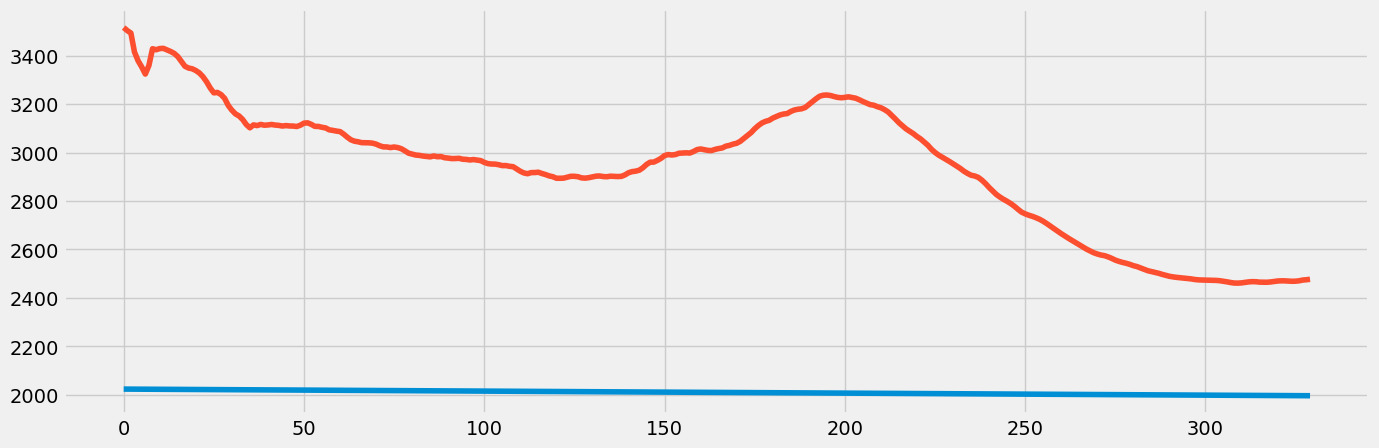

In [10]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [11]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [12]:
data_2.head()

,None,date,value
0,0,2023-06-30,564630.753575
1,1,2023-05-31,560053.375375
2,2,2023-04-30,556300.121045
3,3,2023-03-31,527593.322695
4,4,2023-02-28,514520.034442


In [13]:
# Create a subset with the last 20 years.
data_sub = data_2.loc[(data_2['date'] >= '2003-01-01') & (data_2['date'] < '2023-05-01')]

**Limiting the range to the last 20 years, in order to see a more current picture.**

In [14]:
# Set the "date" column as the index

data_sub['datetime'] = pd.to_datetime(data_sub['date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,None,value
datetime,,
2023-04-30,2,556300.121045
2023-03-31,3,527593.322695
2023-02-28,4,514520.034442
2023-01-31,5,505233.900662
2022-12-31,6,494493.482599


In [15]:
# removing column
data_sub = data_sub.drop(columns = ['None'])

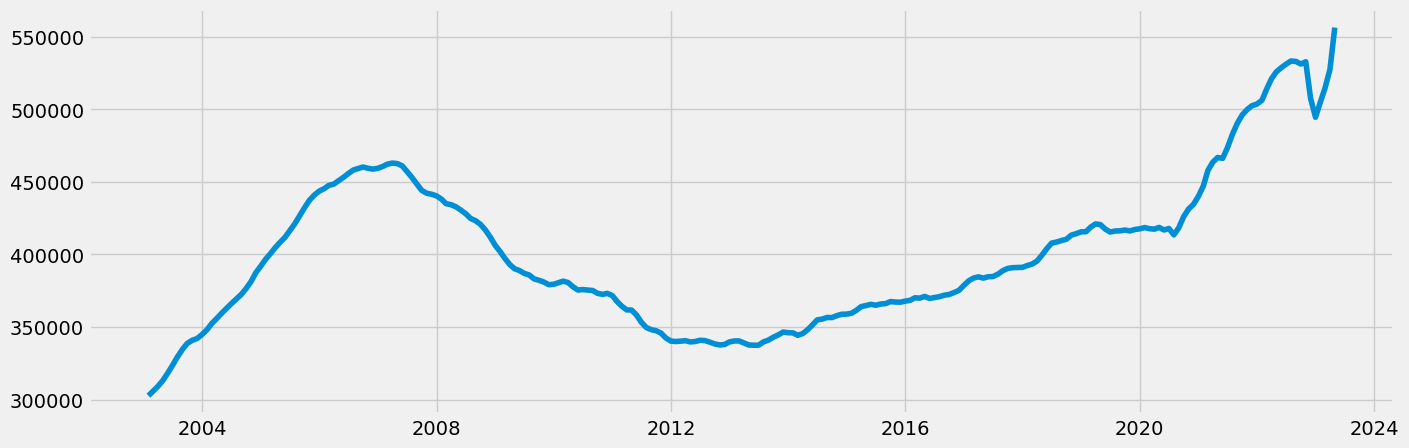

In [16]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [17]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

value    0
dtype: int64

In [18]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()


0

In [19]:
data_sub.head()

,value
datetime,
2023-04-30,556300.121045
2023-03-31,527593.322695
2023-02-28,514520.034442
2023-01-31,505233.900662
2022-12-31,494493.482599


### 3. Time-series analysis: decomposition

In [20]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [21]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

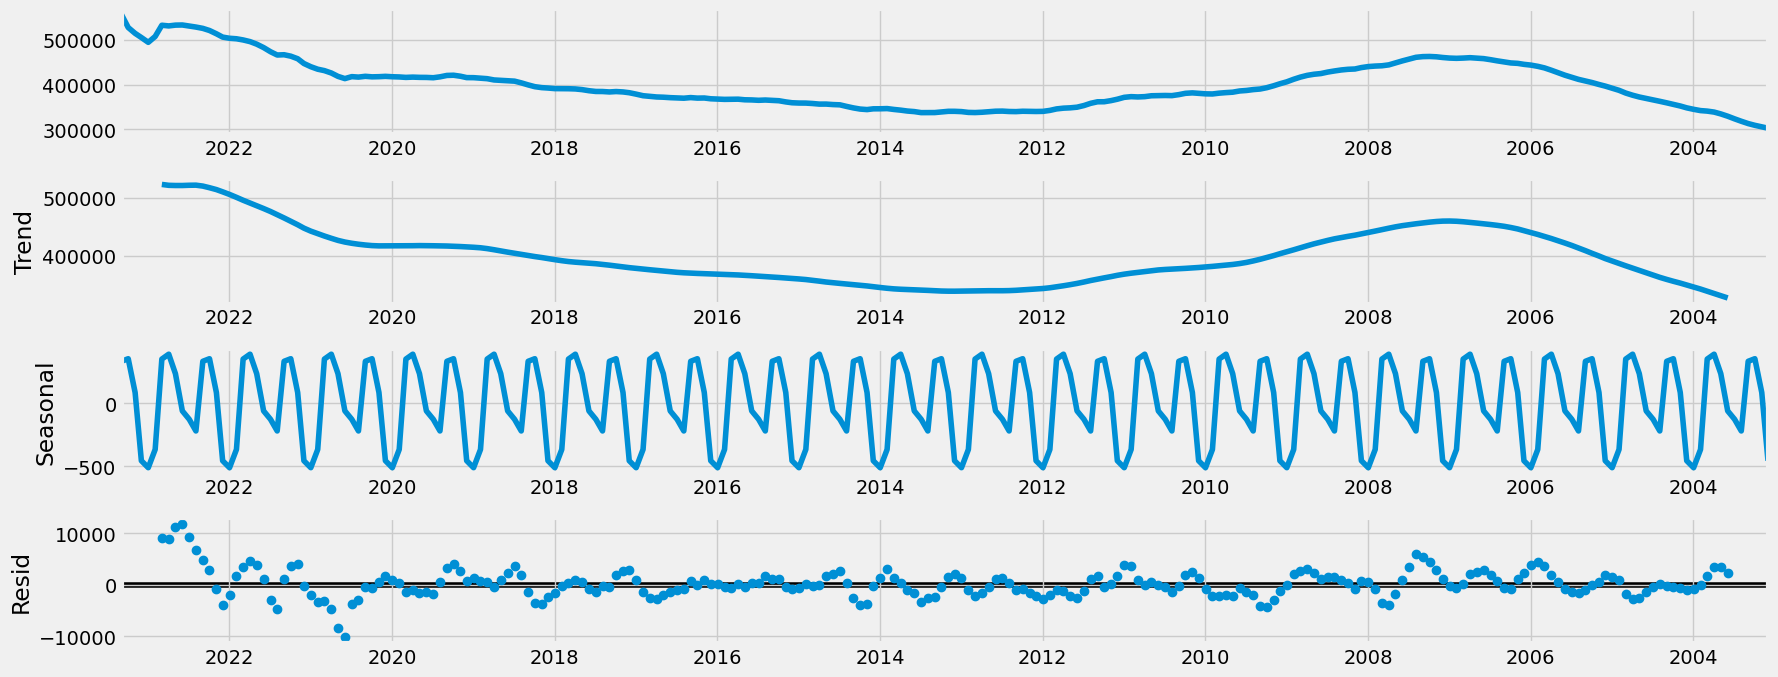

In [22]:
# Plot the separate components

decomposition.plot()
plt.show()

**Timeline is reversed, will plot a new one in reverse.**

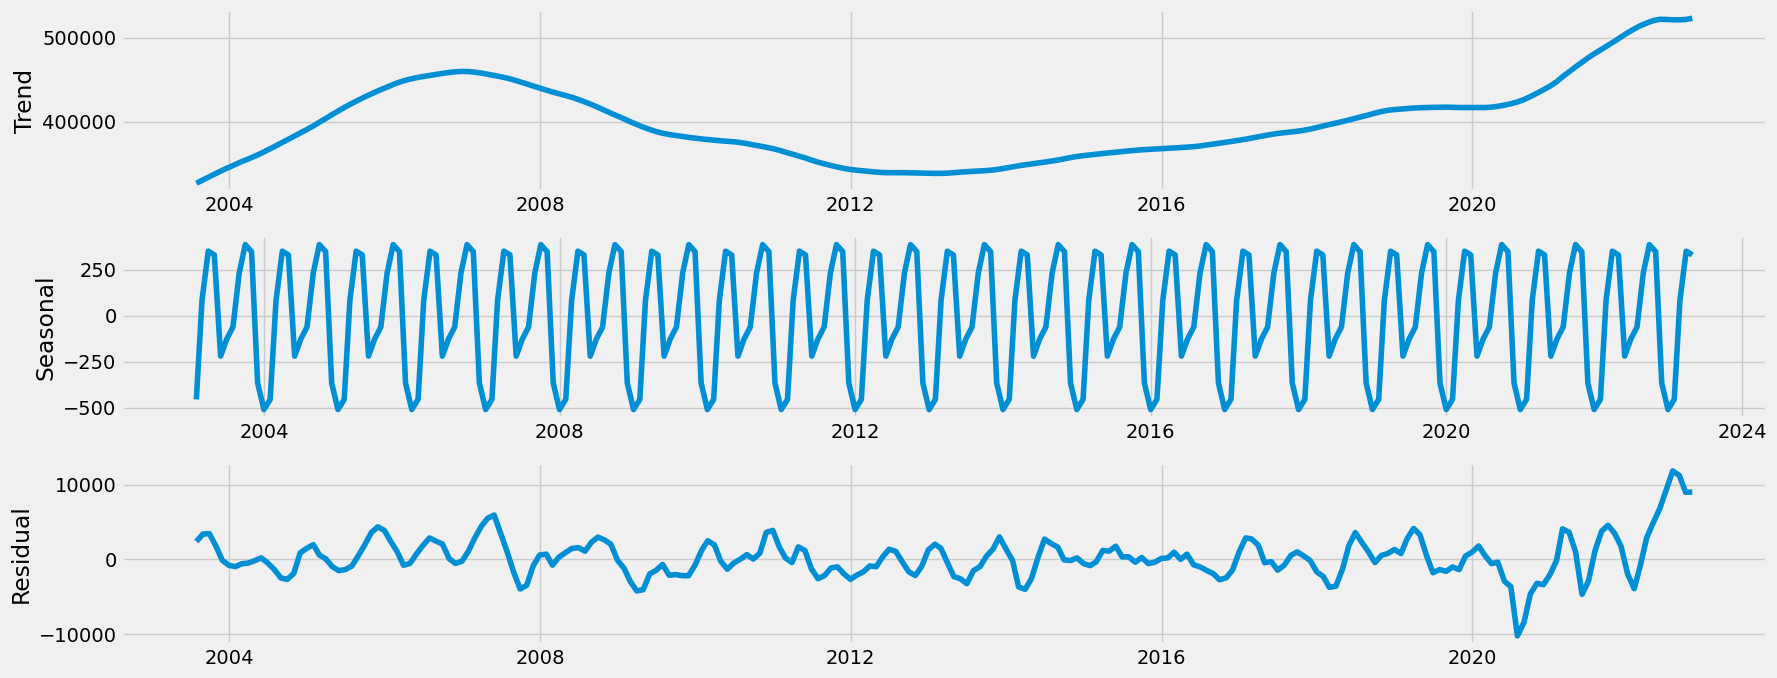

In [23]:
# Reverse the order of components for the plot
components = [decomposition.resid, decomposition.seasonal, decomposition.trend]
component_names = ['Residual', 'Seasonal', 'Trend']
# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 7))
for ax, comp_name, comp in zip(axes, component_names[::-1], components[::-1]):
    ax.plot(comp)
    ax.yaxis.tick_left() 
    ax.set_ylabel(comp_name)

plt.tight_layout()
plt.show()

**The trend shows an initial period of groth, followed by a decline and a gradual recover, followed by a sudden spike around 2021. Seasonality is present, indicating specific periods when property prices consistently incresed or decreased.
The residual stays close to 0 but with many variations suggesting that there is noise that the trend and the seasonality cannot explain.**

### 4. Testing for stationarity

In [24]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.319841
p-value                          0.620047
Number of Lags Used             15.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64


**The null hypothesis cannot be dismised since the test statistic exceeds the critical value.
The outcome of the test lacks significance due to the p-value being greater than 0.05.
In this instance the Critical Value (5%) is -2.874245, 
which is lower than the Test Statistic at -1.388139. 
This indicates the presence of a unit root in the data and signifies that the data is not stationary.**

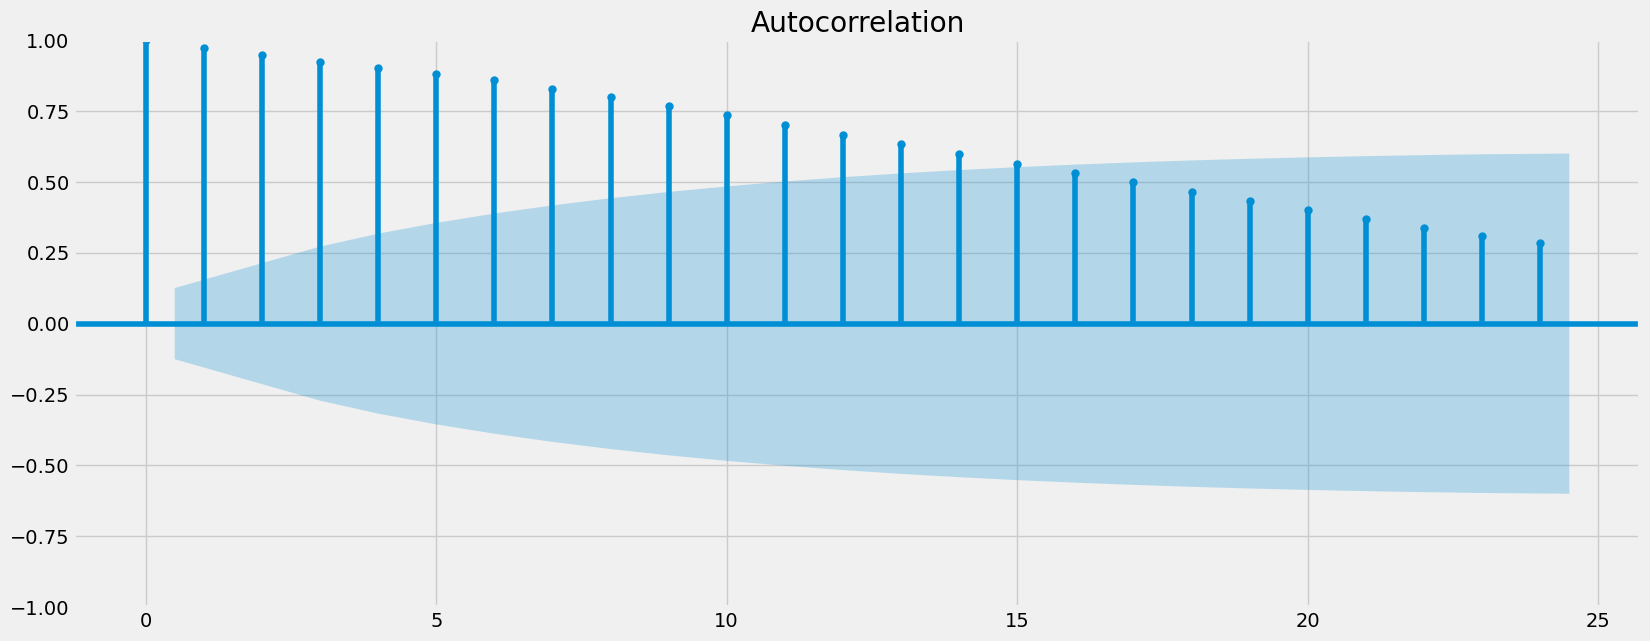

In [25]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

**The data has quite a few lags correlated with each other.
This means there’s a lot of autocorrelated data and the set is likely non-stationary,
which supports the result of the Dickey-Fuller test.**

### 5. Stationarizing the Data

In [26]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [27]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [28]:
data_diff.head()

,value
datetime,
2023-03-31,-28706.798350
2023-02-28,-13073.288253
2023-01-31,-9286.133780
2022-12-31,-10740.418063
2022-11-30,13046.208761


In [29]:
data_diff.columns

Index(['value'], dtype='object')

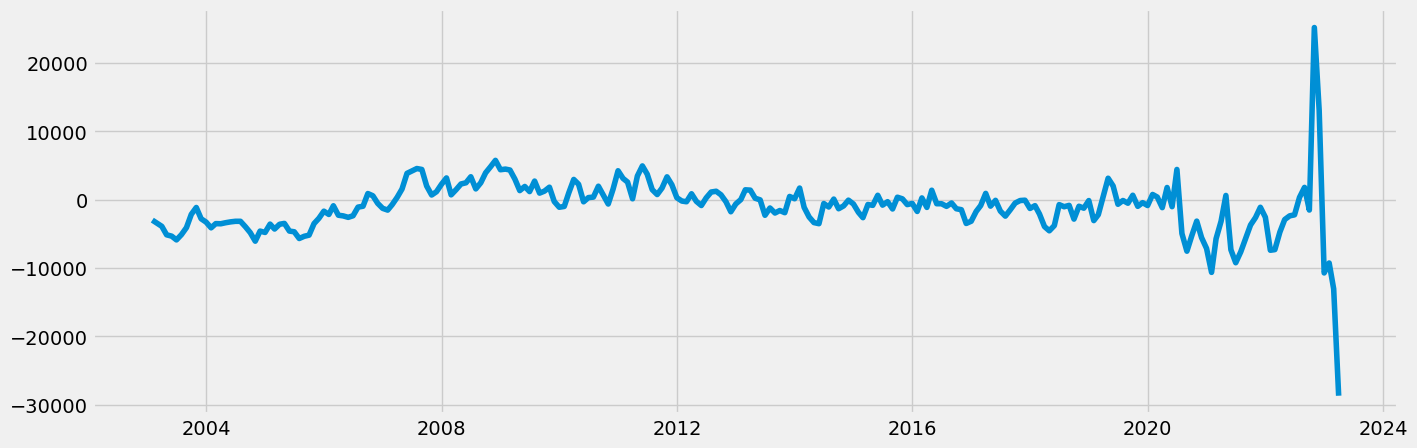

In [30]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [31]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.600678
p-value                          0.092857
Number of Lags Used             14.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64


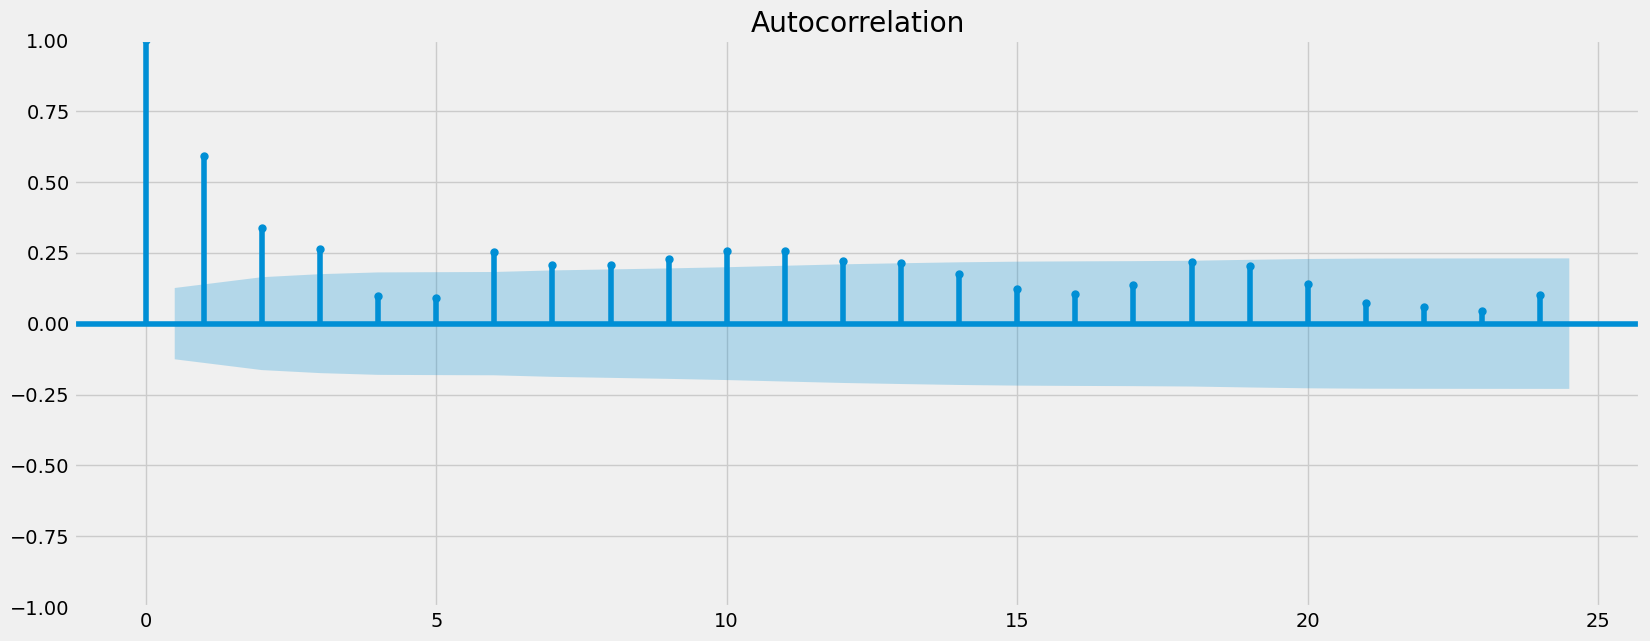

In [32]:
plot_acf(data_diff)
plt.show()

**Still too many lags correlated with each other. Will need to conduct another round of differencing.**

In [33]:
data_diff_2 = data_diff - data_diff.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [34]:
data_diff_2.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [35]:
data_diff_2.head()

,value
datetime,
2023-02-28,15633.510096
2023-01-31,3787.154473
2022-12-31,-1454.284282
2022-11-30,23786.626823
2022-10-31,12117.099880


In [36]:
data_diff_2.columns

Index(['value'], dtype='object')

In [37]:
# Check for missing values (you shouldn't have any)

data_diff_2.isnull().sum() 

value    0
dtype: int64

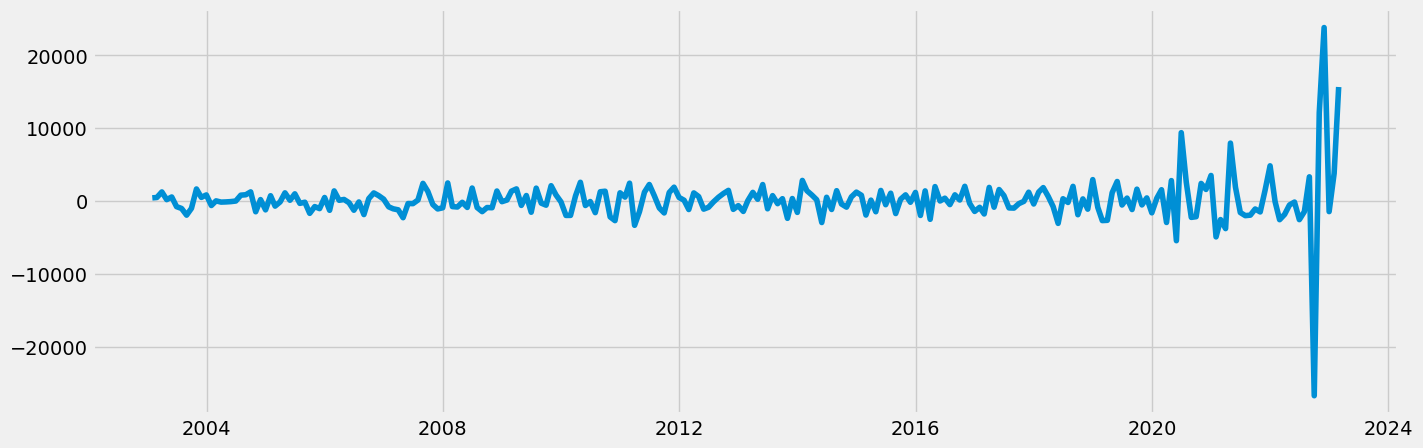

In [38]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [39]:
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                -9.323039e+00
p-value                        9.775681e-16
Number of Lags Used            6.000000e+00
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


**This combination of a highly negative Test Statistic and a very small p-value indicates that the observed data is not likely under the null hypothesis assumption,
and thus, you can conclude that the time series is stationary.**

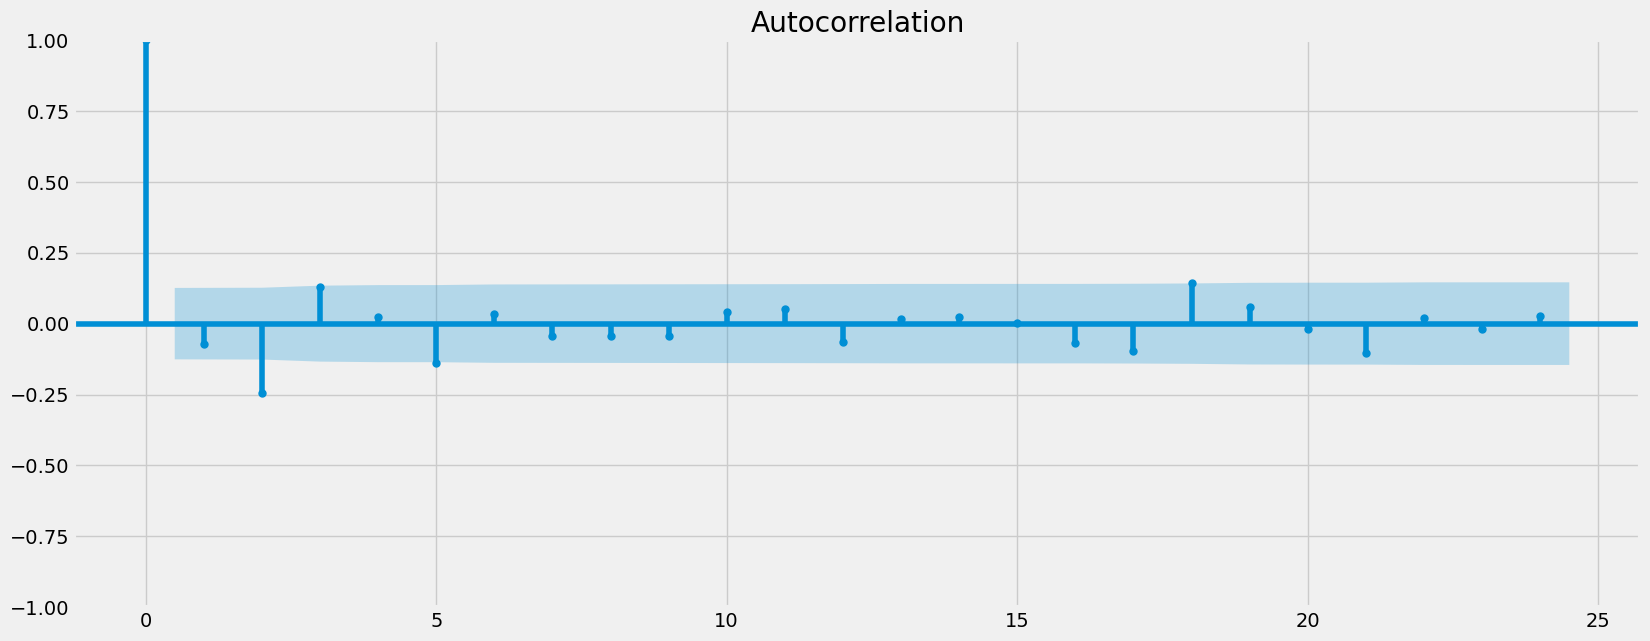

In [40]:
plot_acf(data_diff_2)
plt.show()